MAIN ALGORITHM for Ligand_Optimization.py

- NBGA Fitness Evolution in Ligand Optimization script
- Replicates Table 3 and Figure 11 results from the research paper

Running NBGA for Ligand Optimization...
Generation 0: Best Energy = 1060.9886 Kcal/mol
Generation 20: Best Energy = 1.8298 Kcal/mol
Generation 40: Best Energy = 1.5690 Kcal/mol
Generation 60: Best Energy = 1.5690 Kcal/mol
Generation 80: Best Energy = 1.5690 Kcal/mol

Best Ligand: [8, 1, 2, 2, 3, 3, 8, 8, 8, 8]
Best Energy: 1.5690 Kcal/mol


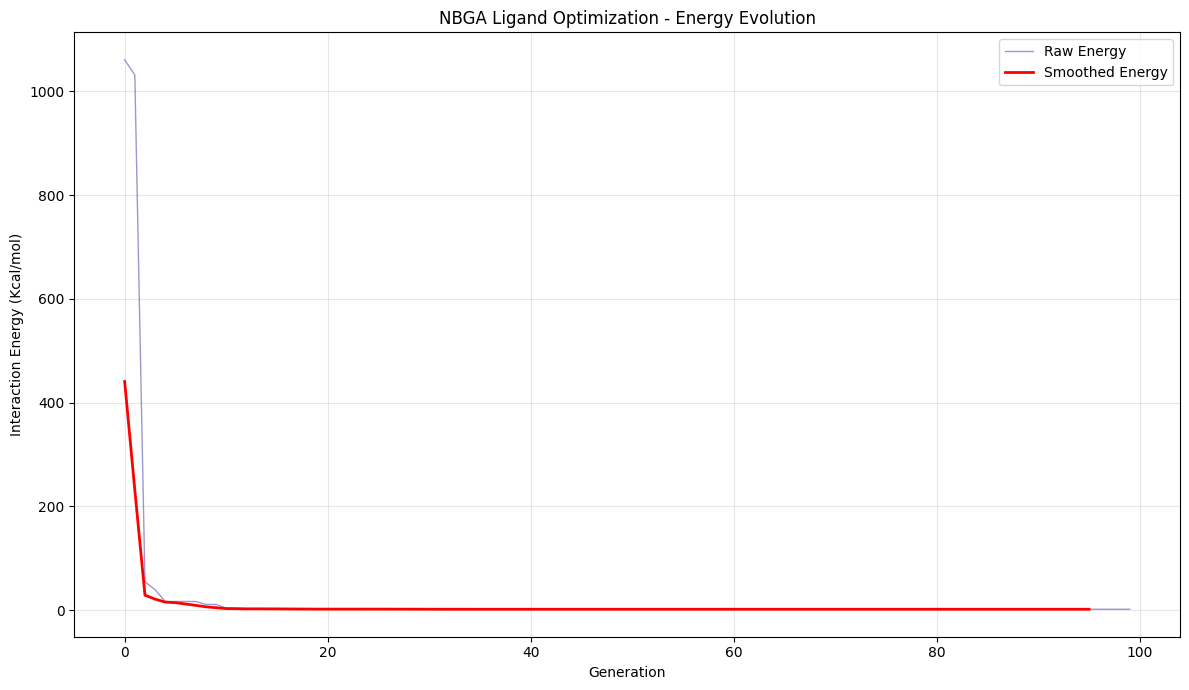

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
import math

# Constants from PDF
C_n = 1e5  # see README.md
C_m = 200  # see README.md
n = 12  # Van der Waals exponent
m = 6   # Van der Waals exponent
K = 100  # Fitness scaling constant

# Functional group bond lengths (Table 2 from PDF)
BOND_LENGTHS = {
    1: 0.65, 2: 1.75, 3: 1.1, 4: 2.2,
    5: 0.01, 6: 1.9, 7: 2.7, 8: 0.0
}

# Protein residue coordinates
RESIDUES = [
    (2.0, 3.0), (4.0, 2.5), (6.0, 3.2), (8.0, 2.8),
    (3.5, 5.0), (5.5, 4.8), (7.5, 5.2), (4.5, 1.0)
]

def calculate_coordinates(chromosome, is_right_tree=True):
    coordinates = []
    base_x = 0.0 if is_right_tree else 0.0

    for i, group in enumerate(chromosome):
        if group == 8:
            continue
        x = base_x + BOND_LENGTHS[group] * (i + 1)
        y = 2.0 + (i % 3) * 0.5
        coordinates.append((x, y))

    return coordinates

def vdw_energy(r):
    if r < 0.7 or r > 2.7:
        return 1000
    return (C_n / (r**n)) - (C_m / (r**m))

def compute_interaction_energy(chromosome):
    coords = calculate_coordinates(chromosome)
    empty_count = chromosome.count(8)
    if len(coords) == 0 or empty_count > len(chromosome) // 2:
        return 1e6
    total_energy = 0
    for group_coord in coords:
        min_energy = float('inf')
        for residue_coord in RESIDUES:
            distance = math.sqrt((group_coord[0] - residue_coord[0])**2 + 
                                 (group_coord[1] - residue_coord[1])**2)
            energy = vdw_energy(distance)
            min_energy = min(min_energy, energy)
        total_energy += min_energy
    return total_energy

def create_ring_topology(population):
    shuffled = population.copy()
    random.shuffle(shuffled)
    return shuffled

def trio_selection(parent, child1, child2):
    candidates = [parent, child1, child2]
    energies = [compute_interaction_energy(c) for c in candidates]
    best_idx = energies.index(min(energies))
    return candidates[best_idx]

def crossover(parent1, parent2):
    if len(parent1) != len(parent2):
        min_len = min(len(parent1), len(parent2))
        parent1, parent2 = parent1[:min_len], parent2[:min_len]

    point = random.randint(1, len(parent1) - 1)
    child1 = parent1[:point] + parent2[point:]
    child2 = parent2[:point] + parent1[point:]
    return child1, child2

def mutate(chromosome, rate=0.1):
    mutated = chromosome.copy()
    for i in range(len(mutated)):
        if random.random() < rate:
            mutated[i] = random.randint(1, 8)
    return mutated

def rolling_average(data, window_size=5):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def nbga_ligand_optimization(pop_size=50, generations=100, tree_size=10):
    random.seed(42)
    population = []
    for _ in range(pop_size):
        chromosome = [random.randint(1, 8) for _ in range(tree_size)]
        population.append(chromosome)

    best_energies = []

    for gen in range(generations):
        ring_parents = create_ring_topology(population)
        new_population = []

        for i in range(0, len(ring_parents), 2):
            p1 = ring_parents[i]
            p2 = ring_parents[(i + 1) % len(ring_parents)]

            c1, c2 = crossover(p1, p2)
            c1 = mutate(c1)
            c2 = mutate(c2)

            selected1 = trio_selection(p1, c1, c2)
            selected2 = trio_selection(p2, c1, c2)

            new_population.extend([selected1, selected2])

        population = new_population[:pop_size]

        best_energy = min(compute_interaction_energy(ind) for ind in population)
        best_energies.append(best_energy)

        if gen % 20 == 0:
            print(f"Generation {gen}: Best Energy = {best_energy:.4f} Kcal/mol")

    best_individual = min(population, key=compute_interaction_energy)
    return best_individual, best_energies

def main():
    # Customizable parameters
    pop_size = 50
    generations = 100
    tree_size = 10
    window_size = 5

    print("Running NBGA for Ligand Optimization...")
    best_ligand, energy_progress = nbga_ligand_optimization(
        pop_size=pop_size, generations=generations, tree_size=tree_size
    )
    smoothed_energy = rolling_average(energy_progress, window_size=window_size)

    print(f"\nBest Ligand: {best_ligand}")
    print(f"Best Energy: {compute_interaction_energy(best_ligand):.4f} Kcal/mol")

    plt.figure(figsize=(12, 7))
    plt.plot(energy_progress, alpha=0.4, color='darkblue', linewidth=1, label="Raw Energy")
    plt.plot(range(len(smoothed_energy)), smoothed_energy, color='red', linewidth=2, label="Smoothed Energy")
    plt.xlabel("Generation")
    plt.ylabel("Interaction Energy (Kcal/mol)")
    plt.title("NBGA Ligand Optimization - Energy Evolution")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    plt.close()

if __name__ == "__main__":
    main()
